# CNNGeometric demo notebook
This notebook shows how to run a trained model on a given image pair

## Imports

In [1]:
from __future__ import print_function, division
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from cnngeometric_pytorch.model.cnn_geometric_model import CNNGeometric
#from cnngeometric_pytorch.data.pf_dataset import PFDataset
#from cnngeometric_pytorch.data.download_datasets import download_PF_willow
from cnngeometric_pytorch.image.normalization import NormalizeImageDict, normalize_image
from cnngeometric_pytorch.util.torch_util import BatchTensorToVars, str_to_bool
from cnngeometric_pytorch.geotnf.transformation import GeometricTnf
#from cnngeometric_pytorch.geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict

warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

## Parameters

In [2]:
feature_extraction_cnn = 'vgg'

if feature_extraction_cnn=='vgg':
    model_aff_path = 'saved_models/affine_grid.pth.tar'
    #model_aff_path = 'trained_models/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar'
    model_tps_path = 'trained_models/best_streetview_checkpoint_adam_tps_grid_loss_PAMI.pth.tar'
elif feature_extraction_cnn=='resnet101':
    model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss_resnet_random.pth.tar'
    model_tps_path = 'trained_models/best_pascal_checkpoint_adam_tps_grid_loss_resnet_random.pth.tar'   


## Load models

In [3]:
use_cuda = False # torch.cuda.is_available()
do_aff = not model_aff_path==''
do_tps = not model_tps_path==''
do_tps = False
# Create model
print('Creating CNN model...')
if do_aff:
    model_aff = CNNGeometric(output_dim=6,use_cuda=use_cuda,feature_extraction_cnn=feature_extraction_cnn)
if do_tps:
    model_tps = CNNGeometric(output_dim=18,use_cuda=use_cuda,feature_extraction_cnn=feature_extraction_cnn)
    
# Load trained weights
print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])
if do_tps:
    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps.load_state_dict(checkpoint['state_dict'])

Creating CNN model...
Loading trained model weights...


## Create image transformers

In [4]:
#tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)

## Load and preprocess images

In [5]:
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 
normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
import numpy as np
from torch.autograd import Variable
def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

In [6]:
def evaluateImages(source_image_path, target_image_path):

    source_image = io.imread(source_image_path)
    target_image = io.imread(target_image_path)

    source_image_var = preprocess_image(source_image)
    target_image_var = preprocess_image(target_image)

    if use_cuda:
        source_image_var = source_image_var.cuda()
        target_image_var = target_image_var.cuda()

    batch = {'source_image': source_image_var, 'target_image':target_image_var}
    resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda)
    model_aff.eval()
    print(batch['source_image'].shape)
    theta_aff=model_aff(batch)
    warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))
    # warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    # plt.imshow(warped_image_aff_np)

    print(theta_aff.view(-1,2,3))

    if do_aff:
        model_aff.eval()
    # if do_tps:
    #     model_tps.eval()

    # Evaluate models
    if do_aff:
        theta_aff=model_aff(batch)
        warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))

    # if do_tps:
    #     theta_tps=model_tps(batch)
    #     warped_image_tps = tpsTnf(batch['source_image'],theta_tps)

    # if do_aff and do_tps:
    #     theta_aff_tps=model_tps({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
    #     warped_image_aff_tps = tpsTnf(warped_image_aff,theta_aff_tps)


    # Un-normalize images and convert to numpy
    if do_aff:
        warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

    # if do_tps:
    #     warped_image_tps_np = normalize_image(resizeTgt(warped_image_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

    # if do_aff and do_tps:
    #     warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()


    return (source_image, target_image, warped_image_aff_np)


In [7]:
def drawPlot(results):

    fig, axs = plt.subplots(len(results),3)

    for index, (source_image, target_image, warped_image_aff_np) in enumerate(results):

        if index == 0:
            axs[index][0].set_title('src')
            axs[index][1].set_title('tgt')
            axs[index][2].set_title('aff')

        axs[index][0].imshow(source_image)
        axs[index][1].imshow(target_image)
        axs[index][2].imshow(warped_image_aff_np)
            
        for i in range(3):
            axs[index][i].axis('off')

    fig.set_dpi(200)
    fig.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [8]:
src1='/home/nas2_userH/yeojeongpark/compression/dataset/Cityscapes_sequence/leftImg8bit/val/munster/munster_000173_000001_leftImg8bit.png'
tgt1='/home/nas2_userH/yeojeongpark/compression/dataset/Cityscapes_sequence/leftImg8bit/val/munster/munster_000173_000002_leftImg8bit.png'

src2='/home/nas2_userH/yeojeongpark/compression/dataset/Cityscapes_sequence/leftImg8bit/val/lindau/lindau_000000_000000_leftImg8bit.png'
tgt2='/home/nas2_userH/yeojeongpark/compression/dataset/Cityscapes_sequence/leftImg8bit/val/lindau/lindau_000000_000001_leftImg8bit.png'

src3='/home/nas2_userH/yeojeongpark/compression/dataset/Cityscapes_sequence/leftImg8bit/val/lindau/lindau_000005_000000_leftImg8bit.png'
tgt3='/home/nas2_userH/yeojeongpark/compression/dataset/Cityscapes_sequence/leftImg8bit/val/lindau/lindau_000005_000001_leftImg8bit.png'



torch.Size([1, 3, 240, 240])
torch.Size([1, 512, 15, 15])
torch.Size([1, 225, 15, 15])
tensor([[[ 0.9913,  0.0046, -0.0021],
         [ 0.0212,  0.9866, -0.0107]]], grad_fn=<ViewBackward>)
torch.Size([1, 512, 15, 15])
torch.Size([1, 225, 15, 15])
torch.Size([1, 3, 240, 240])
torch.Size([1, 512, 15, 15])
torch.Size([1, 225, 15, 15])
tensor([[[ 1.0173,  0.0161,  0.0086],
         [ 0.0281,  0.9805, -0.0013]]], grad_fn=<ViewBackward>)
torch.Size([1, 512, 15, 15])
torch.Size([1, 225, 15, 15])
torch.Size([1, 3, 240, 240])
torch.Size([1, 512, 15, 15])
torch.Size([1, 225, 15, 15])
tensor([[[ 1.0027,  0.0120, -0.0048],
         [ 0.0086,  0.9877,  0.0023]]], grad_fn=<ViewBackward>)
torch.Size([1, 512, 15, 15])
torch.Size([1, 225, 15, 15])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


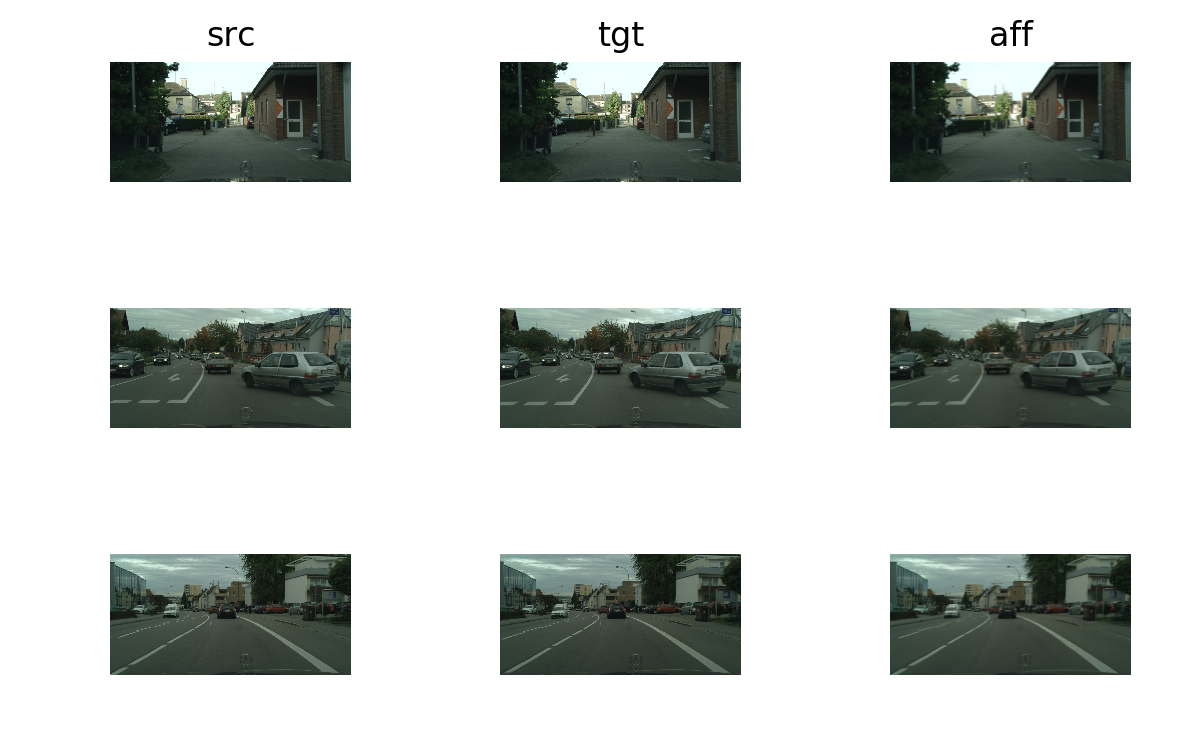

In [9]:
image_array = [(src1, tgt1), (src2, tgt2), (src3, tgt3)]

results = [evaluateImages(src, tgt) for src, tgt in image_array]

drawPlot(results)

In [99]:


src4='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/001/001_00001.jpg'
tgt4='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/001/001_00002.jpg'

src5='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/040/040_00001.jpg'
tgt5='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/040/040_00003.jpg'

src6='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/047/047_00118.jpg'
tgt6='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/047/047_00119.jpg'



(1080, 1920, 3)
torch.Size([1, 3, 240, 240])
torch.Size([1, 3, 240, 240])
tensor([[[ 0.9898, -0.0533, -0.0099],
         [ 0.0029,  0.9714,  0.0203]]], grad_fn=<ViewBackward>)
(1080, 1920, 3)
torch.Size([1, 3, 240, 240])
torch.Size([1, 3, 240, 240])
tensor([[[ 0.9401, -0.0352,  0.0618],
         [ 0.0177,  0.8806, -0.0847]]], grad_fn=<ViewBackward>)
(1080, 1920, 3)
torch.Size([1, 3, 240, 240])
torch.Size([1, 3, 240, 240])
tensor([[[ 0.9879,  0.0913,  0.0338],
         [ 0.0110,  0.9441, -0.0108]]], grad_fn=<ViewBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


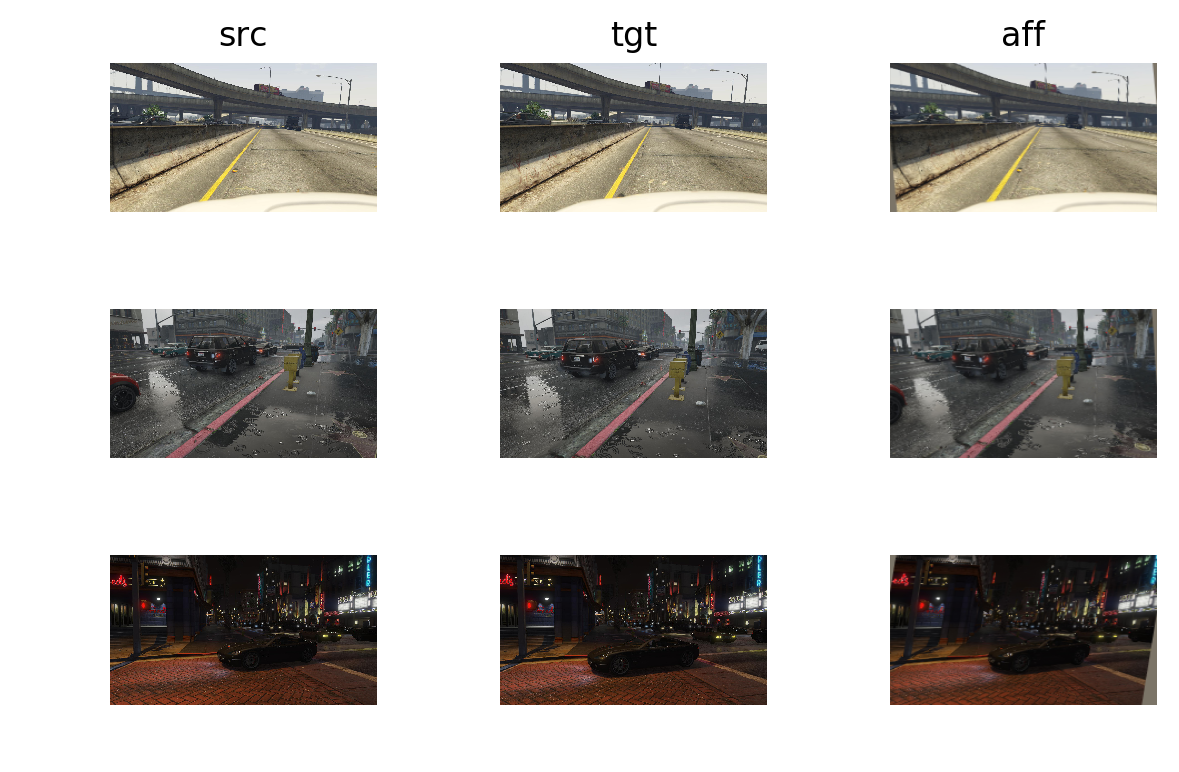

In [100]:
image_array2 = [(src4, tgt4), (src5, tgt5), (src6, tgt6)]

results2 = [evaluateImages(src, tgt) for src, tgt in image_array2]

drawPlot(results2)

In [101]:
imagePath = "/home/nas2_userH/yeojeongpark/compression/dataset"

(1080, 1920, 3)
torch.Size([1, 3, 240, 240])
torch.Size([1, 3, 240, 240])
tensor([[[ 0.9898, -0.0533, -0.0099],
         [ 0.0029,  0.9714,  0.0203]]], grad_fn=<ViewBackward>)
(1080, 1920, 3)
torch.Size([1, 3, 240, 240])
torch.Size([1, 3, 240, 240])
tensor([[[ 1.0074, -0.1059, -0.0398],
         [ 0.0188,  0.9696,  0.0390]]], grad_fn=<ViewBackward>)
(1080, 1920, 3)
torch.Size([1, 3, 240, 240])
torch.Size([1, 3, 240, 240])
tensor([[[ 1.0547, -0.1320, -0.0547],
         [ 0.0172,  0.9815,  0.0554]]], grad_fn=<ViewBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


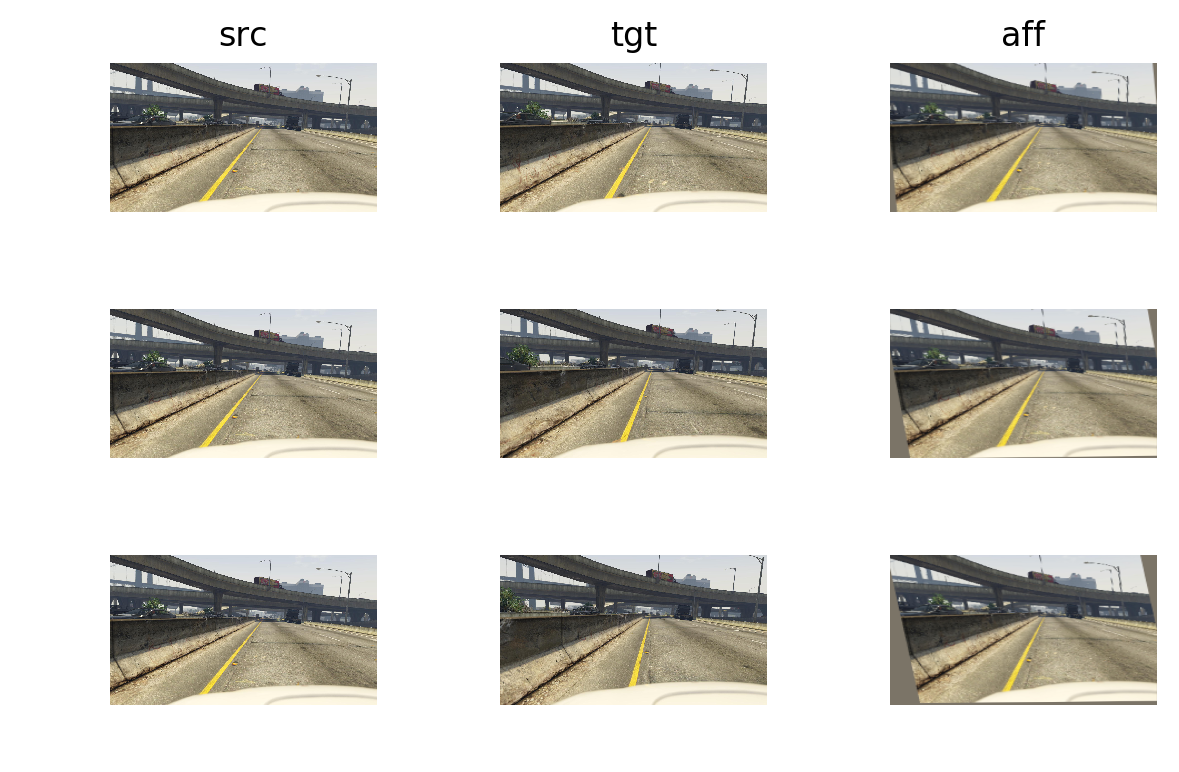

In [52]:

src10='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/001/001_00001.jpg'
tgt10='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/001/001_00002.jpg'

src11='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/001/001_00001.jpg'
tgt11='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/001/001_00003.jpg'

src12='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/001/001_00001.jpg'
tgt12='/home/nas2_userH/yeojeongpark/compression/dataset/Viper/val/img/001/001_00004.jpg'

image_array2 = [(src10, tgt10), (src11, tgt11), (src12, tgt12)]

results2 = [evaluateImages(src, tgt) for src, tgt in image_array2]

drawPlot(results2)

tensor([[[ 0.9666, -0.0604, -0.0109],
         [ 0.0083,  0.9772,  0.0206]]], grad_fn=<ViewBackward0>)
tensor([[[ 0.9928, -0.0943, -0.0392],
         [ 0.0349,  0.9779,  0.0429]]], grad_fn=<ViewBackward0>)
tensor([[[ 1.0352, -0.1502, -0.0548],
         [ 0.0296,  0.9840,  0.0577]]], grad_fn=<ViewBackward0>)


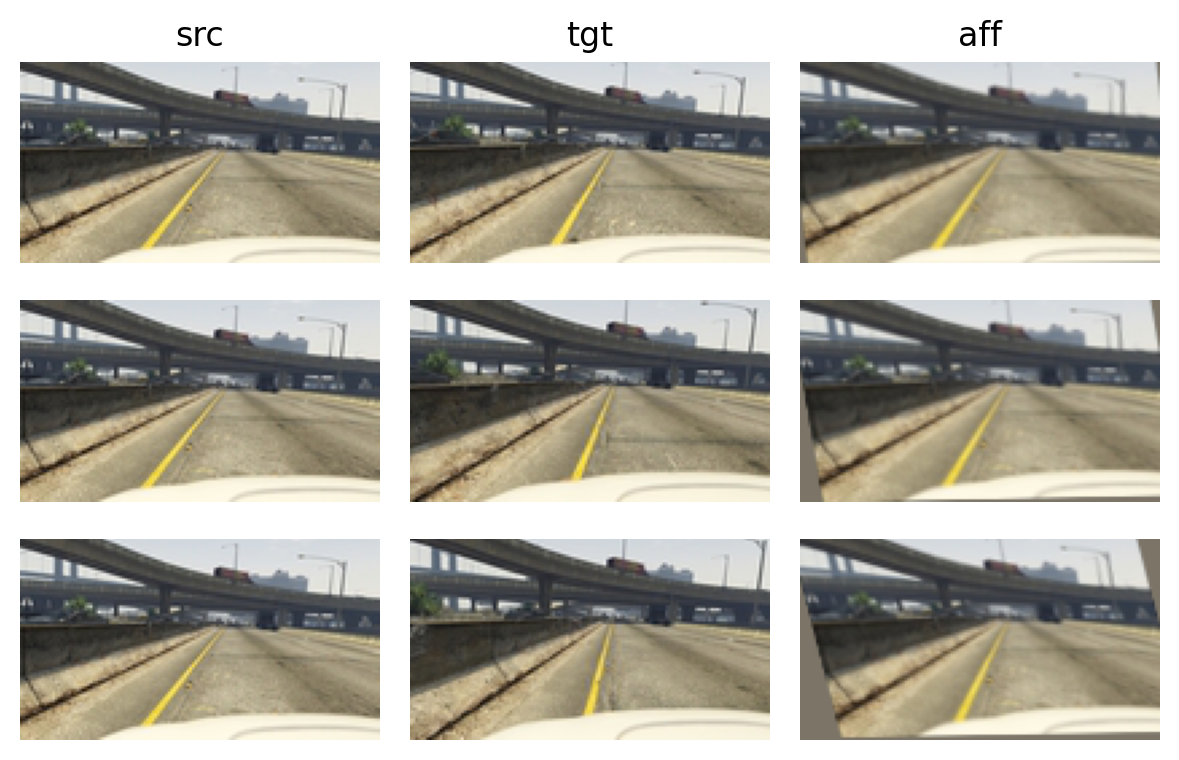

In [118]:

src15='test/001_00001.jpg'
tgt15='test/001_00002.jpg'

src16='test/001_00001.jpg'
tgt16='test/001_00003.jpg'

src17='test/001_00001.jpg'
tgt17='test/001_00004.jpg'

image_array2 = [(src15, tgt15), (src16, tgt16), (src17, tgt17)]

results2 = [evaluateImages(src, tgt) for src, tgt in image_array2]

drawPlot(results2)

In [127]:
print(model_aff)

CNNGeometric(
  (FeatureExtraction): FeatureExtraction(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReL

In [122]:
pytorch_total_params = sum(p.numel() for p in model_aff.parameters())
pytorch_total_params

9261446